## **Clasificación de acentos latinos (v_2.0)**

En este notebook, se busca mejorar el desempeño del modelo entrenado originalmente, realizando ajustes finos y añadiendo una capa de atención temporal al modelo CNN.

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

En principio, se cargan los datos que ya se habían generado anteriormente. Estos datos corresponden al espectrograma de Mel de los audios de Train

In [ ]:
# Cargar el archivo .npz con los datos
data = np.load("mel_Train.npz")

# Extraer características y etiquetas
X = data['X']  # features
y = data['y']  # Etiquetas de clase

## **Preprocesamiento**
En esta sección se procesan las etiquetas de clase, obteniendo las 10 posibles combinaciones para la clasificación

In [ ]:
##Procesar las etiquetas de clase
# obtener las clases únicas ordenadas (10 posibles combinaciones)
clases = sorted(set(y))

# crear un diccionario para mapear cada etiqueta a un número y viceversa
label_to_index = {}
index_to_label = {}
for i, etiqueta in enumerate(clases):
    label_to_index[etiqueta] = i  # '0 2' → 0, '0 3' → 1, etc.
    index_to_label[i] = etiqueta  #  0 → '0 2'

#transforma las etiquetas del conjunto y en números
y_ok = []
for etiqueta in y:
    indice = label_to_index[etiqueta]
    y_ok.append(indice)

y_ok = np.array(y_ok)

# codificar para clasificación, convertir a one-hot
y_final = to_categorical(y_ok, num_classes=len(clases))

print("Forma de X:", X.shape)
print("Forma de y_final:", y_final.shape)

Forma de X: (1395, 200, 128, 1)
Forma de y_final: (1395, 10)


In [ ]:
print("Etiqueta original:", y[0])
print("Índice asignado:", y_ok[0])
print("Vector one-hot:", y_final[0])
print("Decodificada:", index_to_label[np.argmax(y_final[0])])

Etiqueta original: 0 2
Índice asignado: 0
Vector one-hot: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Decodificada: 0 2


Para el entrenamiento del modelo, se divide el conjunto original en validación y entrenamiento

In [ ]:
from sklearn.model_selection import train_test_split

# Genera dos subconjuntos, train y validacion con 80-20%
X_train, X_val, y_train, y_val = train_test_split(
    X, y_final, test_size=0.2, random_state=42
)

## **Bloque de Atención**
El bloque de atención permite que una red neuronal aprenda a "enfocarse" selectivamente en las partes más relevantes de una secuencia, en este caso, de un espectrograma de audio representado como una secuencia de frames temporales.
En vez de tratar todos los frames como igualmente importantes, el modelo aprende qué momentos contienen más información útil para la clasificación del acento y les asigna más peso.

Esto es útil en tareas como clasificación de acentos, donde ciertos sonidos o transiciones específicas pueden ser más representativos del acento que otros.

Este bloque espera un mapa de características obtenido mediante la CNN, se transforma cada frame en un vector plano y luego se aplica una capa densa para generar un score de relevancia para cada frame. Posteriormente, con softmax, se convierte esa puntuación en probabilidades normalizadas. Así, cada valor indica cuánta atención debe prestar el model a ese frame.
Finalmente, se multiplican los vectores de cada frame por su respectivo peso de atención y se realiza una suma ponderada sobre el tiempo.

El resultado, es un vector de contexto que resume la secuencia, pero enfatizando partes relevantes según el aprendizaje del modelo.

In [ ]:
from tensorflow.keras.layers import Reshape, Dense, Multiply, Lambda, Softmax
import tensorflow.keras.backend as K

def temporal_attention_block(feature_map):
    # Esperamos: (batch, T, F, C)
    T = feature_map.shape[1]
    F = feature_map.shape[2]
    C = feature_map.shape[3]

    # Reorganiza en secuencia temporal
    x = Reshape((T, F * C))(feature_map)  # (batch, T, features)

    # Calcula atención por frame
    attention_scores = Dense(1, activation='tanh')(x)
    attention_weights = Softmax(axis=1)(attention_scores)


    # Aplica atención
    attended = Multiply()([x, attention_weights])             # (batch, T, features)
    context_vector = Lambda(
        lambda x: K.sum(x, axis=1),
        output_shape=lambda s: (s[0], s[2])
    )(attended)

    return context_vector


## **Modelo**
Este bloque implementa el modelo con las modificaciones realizadas. Se utiliza parte de la arquitectura obtenida por la optimización bayesiana, donde se mantienen los siguientes hiperparámetros:
activation: relu;
depth: 4 (de los bloques CNN);
learning_rate: 0.000555287099183203;
optimizer: RMSprop;
batch_size: 32;
initializer: he_normal;
reg_type: l1;
reg_lambda: 0.0002636999467431437;

dropout_rate -> se añade dropout para evitar el sobreajuste debido a la capa de atención
Se añade una capa densa que transforma el vector de contexto (generado por la atención) en una mejor representación y no lineal. Finalmente se incorpora otra capa final antes del clasificador, que reduce la dimensionalidad de manera no lineal, dejando una representación compacta y expresiva.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Normalization, Conv2D, MaxPooling2D, Dropout, Flatten, Dense,BatchNormalization, Activation
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.layers import GlobalAveragePooling2D

normalizer = Normalization()
normalizer.adapt(X_train)  # adaptar solo con X_train, normaliza los datos

input_shape = (200, 128, 1)
inputs = Input(shape=input_shape)

x = normalizer(inputs)

# CNN
x = Conv2D(32, (3, 3), kernel_initializer='he_normal', kernel_regularizer=l1(0.00026369), padding="same")(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), kernel_initializer='he_normal',kernel_regularizer=l1(0.00026369), padding="same")(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3),  kernel_initializer='he_normal',kernel_regularizer=l1(0.00026369), padding="same")(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, (3, 3), kernel_initializer='he_normal',kernel_regularizer=l1(0.00026369), padding="same")(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = temporal_attention_block(x)

x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)

# Salida
output = Dense(10, activation='softmax', name='salida_combinada')(x)

# modelo
model = Model(inputs=inputs, outputs=output)

# compilación
optim = getattr(tf.keras.optimizers, 'RMSprop')(learning_rate=0.00055528)
model.compile(
    optimizer=optim,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ver modelo
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)    │ (None, 200, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_9               │ (None, 200, 128, 1)       │               3 │ input_layer_9[0][0]        │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_36 (Conv2D)            │ (None, 200, 128, 32)      │             320 │ normalization_9[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_36 (Activation)    │ (None, 200, 128, 32)      │               0 │ conv2d_36[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_36              │ (None, 100, 64, 32)       │               0 │ activation_36[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_37 (Conv2D)            │ (None, 100, 64, 64)       │          18,496 │ max_pooling2d_36[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_37 (Activation)    │ (None, 100, 64, 64)       │               0 │ conv2d_37[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_37              │ (None, 50, 32, 64)        │               0 │ activation_37[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_38 (Conv2D)            │ (None, 50, 32, 128)       │          73,856 │ max_pooling2d_37[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_38 (Activation)    │ (None, 50, 32, 128)       │               0 │ conv2d_38[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_38              │ (None, 25, 16, 128)       │               0 │ activation_38[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_39 (Conv2D)            │ (None, 25, 16, 256)       │         295,168 │ max_pooling2d_38[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_39 (Activation)    │ (None, 25, 16, 256)       │               0 │ conv2d_39[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_39              │ (None, 12, 8, 256)        │               0 │ activation_39[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_9 (Reshape)           │ (None, 12, 2048)          │               

 Total params: 661,070 (2.52 MB)

 Trainable params: 661,067 (2.52 MB)

 Non-trainable params: 3 (16.00 B)

## **Entrenamiento**
Se entrena el modelo con los hiperparámetros mencionados anteriormente

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),  # también one-hot
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
    verbose=1
)


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 285ms/step - accuracy: 0.0991 - loss: 7.0850 - val_accuracy: 0.1039 - val_loss: 5.8755
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step - accuracy: 0.1163 - loss: 5.7615 - val_accuracy: 0.2401 - val_loss: 5.2022
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.2274 - loss: 5.0443 - val_accuracy: 0.3441 - val_loss: 4.3424
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - accuracy: 0.3954 - loss: 4.2195 - val_accuracy: 0.4875 - val_loss: 3.5822
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 267ms/step - accuracy: 0.5102 - loss: 3.5758 - val_accuracy: 0.4444 - val_loss: 3.4427
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.5684 - loss: 3.1950 - val_accuracy: 0.7527 - val_loss: 2.7745
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - accuracy: 0.6842 - loss: 2.7615 - val_accuracy: 0.6237 - val_loss: 2.6916
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.6929 - loss: 2.5948 - va

## Evaluación

Para evaluar el desempeño del modelo entrenado, se realizaron predicciones sobre el conjunto de validación. Estas predicciones fueron convertidas a clases usando argmax, tanto para las etiquetas verdaderas como para las predichas. Luego, cada índice se tradujo nuevamente a su etiqueta original combinada, haciendo el análisis más interpretable de acuerdo al diccionario original.

Se generó un reporte de clasificación, que incluye las métricas de precisión, recall y F1-score por clase. Además, se imprimió la matriz de confusión, que permite visualizar cómo se distribuyen los errores del modelo. Por último, se calcularon las dos métricas globales de desempeño: el macro F1-score y el macro recall, que entregan un promedio equitativo del rendimiento en cada clase.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

y_val_pred = tf.argmax(model.predict(X_val), axis=1).numpy()
y_val_true = tf.argmax(y_val, axis=1).numpy()

print("Macro F1-score:", f1_score(y_val_true, y_val_pred, average='macro'))

# Macro Recall
macro_recall = recall_score(y_val_true, y_val_pred, average='macro')
print("Macro Recall:", macro_recall)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Macro F1-score: 0.9743720844100267
Macro Recall: 0.973511244377811


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score

# Predicciones
y_pred_val = model.predict(X_val)
y_true_val = np.argmax(y_val, axis=1)
y_pred_classes = np.argmax(y_pred_val, axis=1)

# Mapeo de índices a etiquetas legibles
y_true_labels = [index_to_label[i] for i in y_true_val]
y_pred_labels = [index_to_label[i] for i in y_pred_classes]

# Reporte más interpretable
print("Reporte de clasificación:")
print(classification_report(y_true_labels, y_pred_labels))

print("Matriz de confusión:")
print(confusion_matrix(y_true_labels, y_pred_labels))

print("\nMacro F1-score:")
print(f1_score(y_true_labels, y_pred_labels, average='macro'))

print("\nMacro Recall:")
print(recall_score(y_true_labels, y_pred_labels, average='macro'))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

         0 2       1.00      1.00      1.00        27
         0 3       0.94      1.00      0.97        30
         0 4       1.00      0.96      0.98        25
         0 5       0.97      1.00      0.98        30
         0 6       0.93      0.93      0.93        29
         1 2       1.00      1.00      1.00        27
         1 3       1.00      0.93      0.96        29
         1 4       0.97      1.00      0.98        31
         1 5       1.00      1.00      1.00        28
         1 6       0.95      0.91      0.93        23

    accuracy                           0.97       279
   macro avg       0.98      0.97      0.97       279
weighted avg       0.98      0.97      0.97       279

Matriz de confusión:
[[27  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 24  0  1  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  1  0  1 27  0  0  

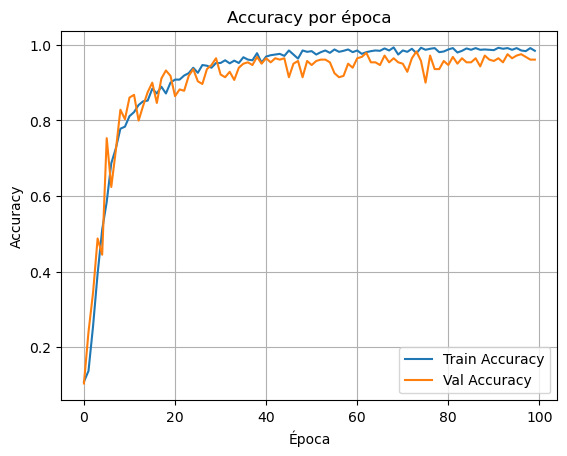

In [ ]:
import matplotlib.pyplot as plt

# === Accuracy ===
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy por época')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


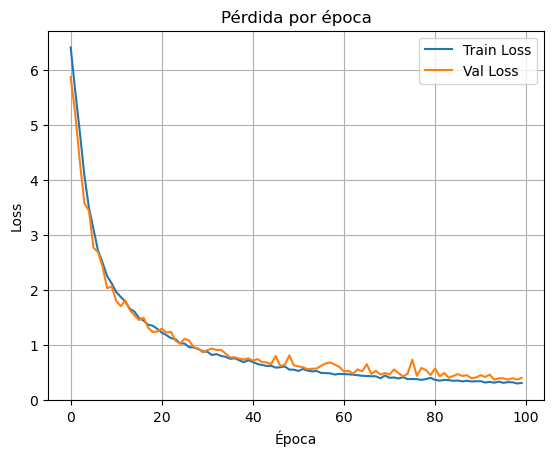

In [ ]:
# === Pérdida (Loss) ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida por época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


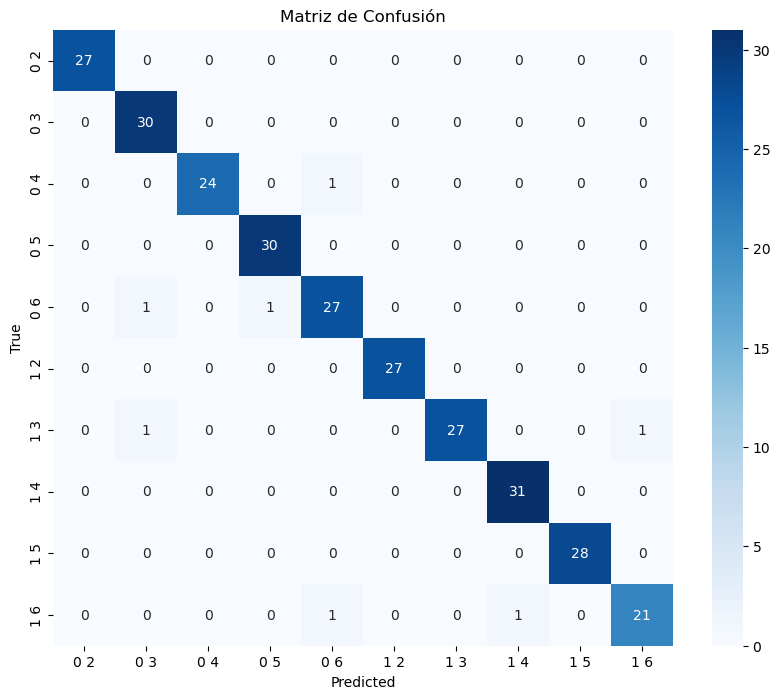

In [ ]:
# Calcular matriz de confusión
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=index_to_label.values(), yticklabels=index_to_label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.show()

## Análisis

En general se observa un muy buen desempeño del modelo, la mayoría de las clases están bien clasificadas y hay muy pocas confusiones, lo cual es excelente.
Accuracy general: 0.97
El modelo logra predecir correctamente el 97% de los ejemplos del conjunto de validación, lo cual es un resultado alto en tareas de clasificación multiclase como esta.

Macro F1-score: 0.974
Esto indica que, en promedio, el modelo mantiene un excelente equilibrio entre precisión y recall en todas las clases, incluso si tienen distintos tamaños.

Macro Recall: 0.973
El modelo identifica correctamente los ejemplos de todas las clases casi por igual, lo que indica que no favorece una clase más que otra.

Los errores se concentran principalmente entre los acentos venezolano y colombiano para mujeres, los cuales confunde levemente el modelo. También hay algunos casos que confunde entre femenino y masculino para acentos como chileno y venezolano.


Guardado del modelo y sus pesos

In [ ]:
model.save("modelo_cnn3.h5")
model.save("modelo_cnn3.keras")
model.save_weights("modelo_cnn3.weights.h5")

Se generó el archivo submission.csv con las predicciones del modelo sobre los datos de prueba. Para ello, se cargaron los espectrogramas de mel_Test.npz y los IDs desde Test.csv. Luego, se obtuvo la clase más probable para cada muestra, se tradujo al formato original de etiquetas y se construyó un DataFrame con los resultados, que fue guardado en CSV para su envío final.

In [ ]:
import pandas as pd

# 1. Cargar los datos de test
data = np.load("mel_Test.npz")
X_test = data["X"]

# 2. Cargar los IDs originales
df_test = pd.read_csv("Test.csv")  # contiene la columna 'Id'

# 3. Predecir con el modelo
y_pred = model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=1)

# 4. Mapear índices a etiquetas como '0 2'
expected_labels = [index_to_label[i] for i in y_pred_indices]

# 5. Crear DataFrame de Submission
df_submission = pd.DataFrame({
    "Id": df_test["Id"],
    "Expected": expected_labels
})

# 6. Guardar como archivo CSV
df_submission.to_csv("submission_2.csv", index=False)
print("Archivo 'submission_2.csv' generado correctamente.")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Archivo 'submission_2.csv' generado correctamente.


In [ ]:
np.mean(X_train), np.mean(X_val), np.mean(X_test)


(-64.664505, -64.32324, -64.5566)

## Conclusiones finales

- El modelo generaliza bien y logra un balance notable entre clases.
- Los errores se concentran en clases cercanas fonéticamente o con patrones acústicos similares.
- La arquitectura con atención temporal y capas densas parece efectiva para esta tarea.
- La métrica macro F1-score de 0.974 confirma un desempeño equilibrado, lo que es ideal en datasets balanceados.
- Incorporar la capa de atención temporal hizo que el modelo se pudiera enfocar en segmentos más relevantes del audio, mejorando su capacidad de discriminación entre acentos similares.
- El modelo logró un macro F1-score de 0.97 en la evaluación final, lo que representa un incremento respecto a la versión sin atención.
- Arquitectura simple y modular: la red es fácil de escalar y simple en su arquitectura.
- Preprocesamiento apropiado: El uso del Espectrograma de Mel como entrada, normalizado y con tamaño fijo, facilitó el entrenamiento eficiente.
- La atención temporal mejoró la representación sin tener que utilizar otro tipo de redes más complejas.